# Assess RNA binding re-parameterisation

While IntaRNA is a powerful RNA binding simulator, it may not account for RNA binding within the context of a cell. Furthermore, for RNA binding reactions where binding occurs less than half of the time (eg K < 1), the simulator does not return a binding energy, which may be zero or positive. For these reasons, experimental data offers a good alternative to map binding energy to binding strength. 

Using relative fluorescence and RNA binding data from paper ["Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs"](https://www.nature.com/articles/nbt.2461#Fig1), a function can be fit that uses relative fluorescence as a proxy for the equilibrium constant K, where higher fluorescence means lower K (less binding) and where a relative fluorescence of 0.5 is equivalent to $K_{eq} = 1$. 

Several challenges for fitting the data include:
- The experimental sequences are long
- The hybridisation energy for the experimental RNA sequences was calculated with UNAFold

In [1]:
from copy import deepcopy
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.style.use('seaborn-v0_8')
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import jax
import diffrax as dfx
from tqdm import tqdm

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')

import bioreaction
from bioreaction.model.data_containers import Impulse
from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState, bioreaction_sim_expanded
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.med_sim import get_int_med_model, basic_de, MedSimParams, MedSimInternalState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from tests.shared import five_circuits, CONFIG
import src
from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.misc.numerical import make_symmetrical_matrix_from_sequence, triangular_sequence
from src.utils.misc.type_handling import flatten_listlike
from src.utils.misc.units import per_mol_to_per_molecule
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols
from src.utils.results.analytics.timeseries import generate_analytics, get_precision, get_sensitivity


config = deepcopy(CONFIG)

jax.devices()

xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


[CpuDevice(id=0)]

Examining previously generated RNA sequences for which the $\Delta G$ has been simulated and translated into 

In [2]:
path_to_stats = 'data/ensemble_generate_circuits/2023_02_24_170946/gather_interaction_stats/circuit_stats.csv'
path_to_stats = os.path.join('..', path_to_stats)

circuit_stats = pd.read_csv(path_to_stats)

In [4]:
cols_energies = [c for c in circuit_stats.columns if 'energies' in c and ('path' not in c)]
cols_eqconstants = [c for c in circuit_stats.columns if 'eqconstants' in c and ('path' not in c)]


From the paper mentioned above, we previously roughly fit a function to the reported RNA binding in Figure 1, as explained in the notebook `explanations/binding_energy.ipynb`. 

In [23]:
def cal_to_j(E_cal):
    return E_cal * 4.184


def j_to_cal(E_j):
    return E_j / 4.184


def F(E):
    """ kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/12.552 + 5))) + 0.01
    return F
    # return 1/(1+np.exp(-(E/3 + 5))) + 0.01


def gibbs_K(E):
    """ In kJ/mol. dG = - RT ln(K) """
    RT = 8.314 * 310
    E = E * 1000
    K = np.exp(-E/(RT))
    return K


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kj/mol """
    return 1/initial * (1/F(E) - 1)


def equilibrium_constant_fluorescence_reparam(E, initial):
    """ The energy input E is \Delta G in kj/mol """
    return 1/initial * (1/F(E) - 1)


ka = per_mol_to_per_molecule(1000000)

We will now check how the equilibrium constants compare if given the energies that were simulated for the binding between RNAs in 200k circuits, each with 3 randomly generated RNAs that can inter- or self-bind.

In [14]:
def div_ka(Keq):
    return np.divide(ka, Keq)

dfm = circuit_stats.melt(id_vars=['name', 'num_interacting', 'num_self_interacting'],
                         value_vars=cols_energies, value_name='energies')
dfm['eqconstants_gibbs'] = dfm['energies'].apply(gibbs_K)
dfm['eqconstants_F'] = dfm['energies'].apply(partial(equilibrium_constant_fluorescence, initial=1))
dfm['kd_rate_gibbs'] = dfm['eqconstants_gibbs'].apply(div_ka)
dfm['kd_rate_F'] = dfm['eqconstants_F'].apply(div_ka)
dfm


,name,num_interacting,num_self_interacting,variable,energies,eqconstants_gibbs,eqconstants_F,kd_rate_gibbs,kd_rate_F
0,toy_mRNA_circuit_0,0,0,energies_0-0,30.00,0.000009,0.000611,171.397367,2.469932
1,toy_mRNA_circuit_100000,0,0,energies_0-0,30.00,0.000009,0.000611,171.397367,2.469932
2,toy_mRNA_circuit_100001,0,0,energies_0-0,30.00,0.000009,0.000611,171.397367,2.469932
3,toy_mRNA_circuit_100002,1,0,energies_0-0,30.00,0.000009,0.000611,171.397367,2.469932
4,toy_mRNA_circuit_100003,0,0,energies_0-0,30.00,0.000009,0.000611,171.397367,2.469932
...,...,...,...,...,...,...,...,...,...
1799995,toy_mRNA_circuit_99999,0,0,energies_2-2,30.00,0.000009,0.000611,171.397367,2.469932
1799996,toy_mRNA_circuit_9999,0,1,energies_2-2,30.00,0.000009,0.000611,171.397367,2.469932
1799997,toy_mRNA_circuit_999,0,1,energies_2-2,30.00,0.000009,0.000611,171.397367,2.469932
1799998,toy_mRNA_circuit_99,0,0,energies_2-2,30.00,0.000009,0.000611,171.397367,2.469932


Text(0.5, 1.0, 'Energy (kJ) from 200k simulated circuits vs. parameterised function')

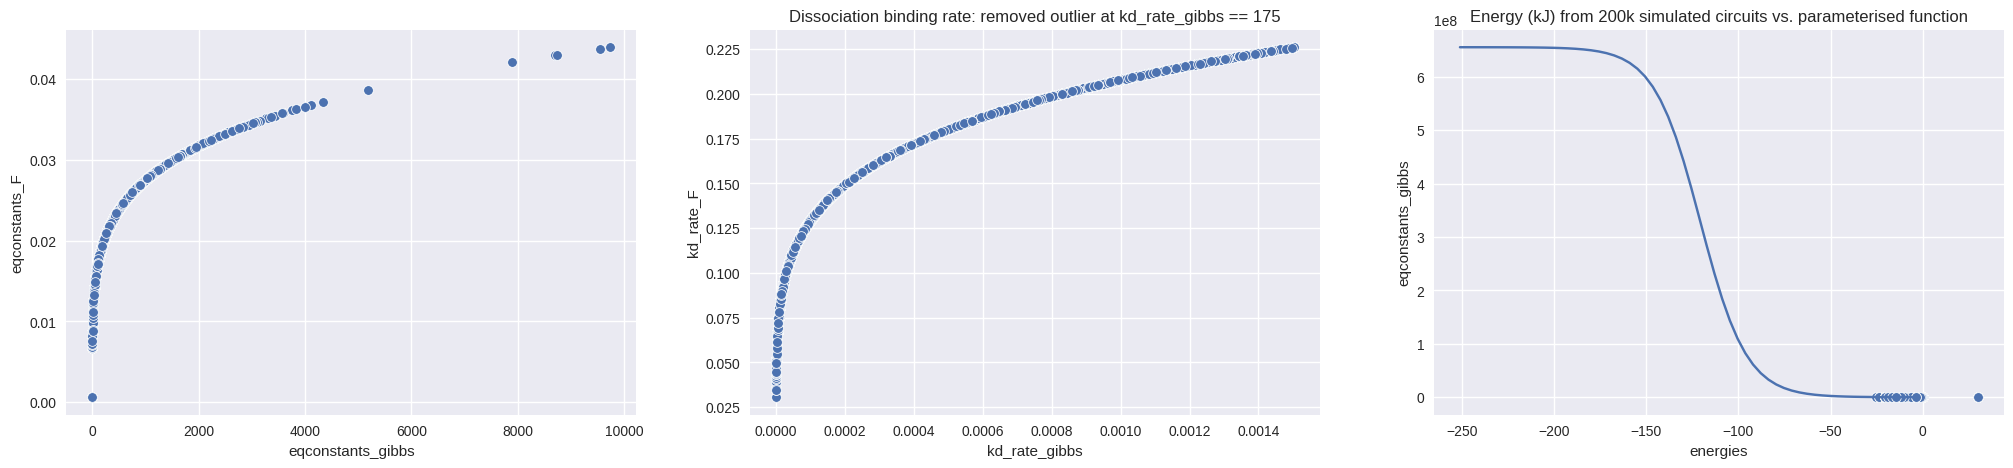

In [47]:
plt.figure(figsize=(25, 5))
ax = plt.subplot(1,3,1)
sns.scatterplot(dfm[dfm['eqconstants_gibbs'] < 15000], x='eqconstants_gibbs', y='eqconstants_F')
ax = plt.subplot(1,3,2)
sns.scatterplot(dfm[dfm['kd_rate_gibbs'] < 25], x='kd_rate_gibbs', y='kd_rate_F')
plt.title('Dissociation binding rate: removed outlier at kd_rate_gibbs == 175')
ax = plt.subplot(1,3,3)
Erange_from_paper = cal_to_j(np.arange(-60, 0))
plt.plot(Erange_from_paper, equilibrium_constant_fluorescence(Erange_from_paper, initial=1))
sns.scatterplot(dfm, x='energies', y='eqconstants_gibbs')
plt.title('Energy (kJ) from 200k simulated circuits vs. parameterised function')

The scale of the  equilibrium constant $K_{eq}$ calculated by our parameterisation function is off.
TODO:
- The point at which K_Fluorescence = 1 should become the new K_gibbs = 1.

In [57]:
v = equilibrium_constant_fluorescence(np.arange(-70, -50, 0.1), initial=1) 
K_mid = round(np.arange(-70, -50, 0.1)[np.argmax(v<=1)], 2)